# Dataloaders for Voxel and ImageVoxel Datasets

In [1]:
from torch.utils.data import Dataset as dset
# from torch.utils.data import DataLoader
import os
import numpy as np
from scipy.io import loadmat
from PIL import Image
import platform

def generate_sample_list(VoxelFolderPath):
    """
    Return a list containing all subpathes, like 02818832_bed/10c15151ebe3d237240ea0cdca7b391a
    """
    categories = sorted(os.listdir(VoxelFolderPath))
    samples = []
    for category in categories:
        ids = sorted(os.listdir(os.path.join(VoxelFolderPath,category)))
        samples += list(map(lambda id:os.path.join(category,id),ids))
    return samples

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class ImageVoxelDset(dset):
    """ Dataset for loading img and corresponding voxel
        Example:        
        dset = ImageVoxelDset('/media/WD/ShapeNet/miniDset/Rendered_Imgs','/media/WD/ShapeNet/miniDset/Voxel')
    """
    def __init__(self,ImageFolderPath,VoxelFolderPath, elevations = np.arange(15,60,15), azimuths = np.arange(0,360,15), 
                 ImgTransform=None,VoxelTransform=None):
        """Assumes ImageFolder and VoxelFolder categories have same name"""
        self.samples = generate_sample_list(VoxelFolderPath)
        self.VoxelFolderPath = VoxelFolderPath
        self.ImageFolderPath = ImageFolderPath
        self.ImgTransform  = ImgTransform
        self.VoxelTransform = VoxelTransform
        self.num_views = len(elevations) * len(azimuths)
        self.image_names = ["e_{0:03d}_r_{1:03d}_0001.png".format(elevation,azimuth) for elevation in elevations for azimuth in azimuths]
    
    def __len__(self):
        return len(self.samples) * self.num_views

    def __getitem__(self,index):
        voxel_data_path = os.path.join(self.VoxelFolderPath,self.samples[index//self.num_views],'models','Voxel_Res_020.mat')
        
        if platform.system() == 'Windows':
            category = self.samples[index//self.num_views].split('\\')[0]
        else:
            category = self.samples[index//self.num_views].split('/')[0]

        image_data_path = os.path.join(self.ImageFolderPath,self.samples[index//self.num_views],self.image_names[index % self.num_views])
        voxel = loadmat(voxel_data_path)['voxels']
        img = pil_loader(image_data_path)
        if self.VoxelTransform is not None:
            voxel = self.VoxelTransform(voxel)
        if self.ImgTransform is not None:
            img = self.ImgTransform(img)
        return img,voxel,category

class VoxelDset(dset):
    """ Dataset for loading only voxel
        Example:        
        dset = ImageVoxelDset('/media/WD/ShapeNet/miniDset/Voxel')
    """
    def __init__(self,VoxelFolderPath,VoxelTransform=None):
        """Assumes ImageFolder and VoxelFolder categories have same name"""
        self.samples = generate_sample_list(VoxelFolderPath)
        self.VoxelFolderPath = VoxelFolderPath
        self.VoxelTransform = VoxelTransform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self,index):
        voxel_data_path = os.path.join(self.VoxelFolderPath,self.samples[index],'models','Voxel_Res_020.mat')
        
        if platform.system() == 'Windows':
            category = self.samples[index].split('\\')[0]
        else:
            category = self.samples[index].split('/')[0]
            
        voxel = loadmat(voxel_data_path)['voxels']
        if self.VoxelTransform is not None:
            voxel = self.VoxelTransform(voxel)
        return voxel,category


# Plotting Functions for Voxels

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_voxels(voxels: np.ndarray, path: str, show=False):
	fig = plt.figure()
	ax = fig.gca(projection='3d')
	ax.voxels(voxels, edgecolor="k")
	if show:
		plt.show()
	plt.savefig(path)

def plot_voxels_pair(v1: np.ndarray, v2: np.ndarray):
	fig = plt.figure(figsize=plt.figaspect(0.5))
	ax = fig.add_subplot(1, 2, 1, projection='3d')
	ax.voxels(v1, edgecolor="k")

	ax = fig.add_subplot(1, 2, 2, projection='3d')
	ax.voxels(v2, edgecolor="k")

	plt.show()
    
def plot_voxels_pair_color(v1: np.ndarray, v2: np.ndarray):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 2, 1, projection='3d')

    ax.voxels(v1, edgecolor="k")

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    colors = np.zeros(v2.shape + (3,))
    high = (v2 > 0.8)
    mid = (v2 > 0.6) & (v2 < 0.8)
    low = (v2 > 0.4) & (v2 < 0.6)
    unsure = (v2 > 0.2) & (v2 < 0.4)

    colors = np.empty(v2.shape, dtype=object)
    colors[high] = 'red'
    colors[mid] = 'yellow'
    colors[low] = 'green'
    colors[unsure] = 'white'

    voxel = high | mid | low | unsure

    ax.voxels(voxel, facecolors=colors, edgecolor="k")

    plt.show()

def plot_voxels_3_color (v1: np.ndarray, v2: np.ndarray, v3: np.ndarray):
    fig = plt.figure(figsize=(15,5), constrained_layout=True)
    ax = fig.add_subplot(1, 3, 1, projection='3d')

    ax.voxels(v1, edgecolor="k")

    ax = fig.add_subplot(1, 3, 2, projection='3d')
    colors = np.zeros(v2.shape + (3,))
    high = (v2 > 0.8)
    mid = (v2 > 0.6) & (v2 < 0.8)
    low = (v2 > 0.4) & (v2 < 0.6)
    unsure = (v2 > 0.2) & (v2 < 0.4)

    colors = np.empty(v2.shape, dtype=object)
    colors[high] = 'red'
    colors[mid] = 'yellow'
    colors[low] = 'green'
    colors[unsure] = 'white'

    voxel = high | mid | low | unsure

    ax.voxels(voxel, facecolors=colors, edgecolor="k")

    ax = fig.add_subplot(1, 3, 3, projection='3d')
    colors = np.zeros(v3.shape + (3,))
    high = (v3 > 0.8)
    mid = (v3 > 0.6) & (v3 < 0.8)
    low = (v3 > 0.4) & (v3 < 0.6)
    unsure = (v3 > 0.2) & (v3 < 0.4)

    colors = np.empty(v3.shape, dtype=object)
    colors[high] = 'red'
    colors[mid] = 'yellow'
    colors[low] = 'green'
    colors[unsure] = 'white'

    voxel = high | mid | low | unsure

    ax.voxels(voxel, facecolors=colors, edgecolor="k")

    plt.show()

# Statistics Helper Function

In [104]:
from sklearn.metrics import average_precision_score
def get_statistics(output, target, type='auto'):
    """
    Returns Accuracy, Precision, and Recall.
    TP: number of voxels correctly predicted as 1
    FP: number of voxels incorreclty predicted as 0
    TN: number of voxels correctly predicted as 0
    FN: number of voxels incorrectly predicted as 1
    """
    # get the correct indices from target
    if type == 'auto':
        output[output >= 0.2] = 1
        output[output < 0.2] = 0
    else:
        output[output >= 0.5] = 1
        output[output < 0.5] = 0
    correct_one_indices = target.nonzero(as_tuple=True)
    correct_zero_indices = (target == 0).nonzero(as_tuple=True)
    
    tp = torch.sum(output[correct_one_indices]).item()
    fp = torch.sum(output[correct_one_indices] == 0).item()
    tn = torch.sum(output[correct_zero_indices] == 0).item()
    fn = torch.sum(output[correct_zero_indices]).item()
    
    accuracy = precision = recall = 0
    
    if tp != 0 or tn != 0:
        accuracy = (tp + tn) / (tp + tn + fp + fn)
    if tp != 0:
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
    
    return np.array([accuracy, precision, recall])

# Model Classes

In [4]:
import numpy as np
# import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.models as models


class ImageNet(nn.Module):
    """
    DEPRECATED. We use the Alexnet model below for the Imagenet.
    Still showing this as it is the Alexnet structure
    """
    def __init__(self, in_channels=3):
        super(ImageNet, self).__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 96, kernel_size=11, stride=4),	# conv1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=96),
            nn.Conv2d(96, 256, kernel_size=5, padding=2, groups=2),	# conv2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=256),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),			# conv3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=384),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),			# conv4
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2),	# conv5
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.fcs = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),                                   # fc6
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),                                  # fc7
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 64),                                    # fc8
        )

    def forward(self, x):
        N, C, H, W = x.shape
        x = self.net(x)
        x = x.reshape(N, -1)
        x = self.fcs(x)
        return x


class Alexnet(nn.Module):
    """Alexnet model used for the imagenet"""
    def __init__(self):
        super(Alexnet, self).__init__()

        self.alexnet = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
        self.fc64 = nn.Linear(1000, 64)
        
        # freeze params to reduce overfitting
        freeze_parms = [
          'alexnet.features.0.weight',
          'alexnet.features.0.bias',
          'alexnet.features.3.weight',
          'alexnet.features.3.bias',
          'alexnet.features.6.weight',
          'alexnet.features.6.bias'
        ]
        
        for name, p in self.alexnet.named_parameters():
            if name in freeze_parms:
                p.requires_grad = False


    def forward(self, x):
        x = self.fc64(self.alexnet(x))
        return x


class Resnet(nn.Module):
    """Resnet model used for the imagenet"""
    def __init__(self):
        super(Resnet, self).__init__()

        self.resnet = models.resnet18(pretrained=True)
        
        # edit structure to get right output dims
        self.resnet.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc64 = nn.Linear(1000, 64)
        
        # freeze part of model
        frozen = 0
        for child in self.resnet.children():
            if frozen < 5:
                for param in child.parameters():
                    param.requires_grad = False
                frozen += 1

    def forward(self, x):
        x = self.fc64(self.resnet(x))
        return x

    
class Reconst(nn.Module):
    def __init__(self, in_channels=64):
        super(Reconst, self).__init__()

        self.reconst = nn.Linear(in_channels, 216)

    def forward(self, x):
        h = self.reconst(x)
        h = h.reshape((-1, 1, 6, 6, 6))
        return h

class Encoder(nn.Module):
    def __init__(self, in_channels=1):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv3d(in_channels, 96, kernel_size=7, stride=1),
            nn.PReLU(),
            nn.Conv3d(96, 256, kernel_size=5, stride=1),
            nn.PReLU(),
            nn.Conv3d(256, 384, kernel_size=3, stride=1),
            nn.PReLU(),
            nn.Conv3d(384, 256, kernel_size=3, stride=1),
            nn.PReLU(),
            # nn.Linear(256, 64)
        )

        self.fc64 = nn.Linear(256 * 6 * 6 * 6, 64)

    def forward(self, x):
        N, C, D1, D2, D3 = x.shape
        x = self.encoder(x)
        x = x.reshape(N, -1)
        x = self.fc64(x)
        return x

class Decoder(nn.Module):
    def __init__(self, in_channels=1):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(in_channels, 256, kernel_size=3, stride=1),	# deconv4
            nn.PReLU(),
            nn.ConvTranspose3d(256, 384, kernel_size=3, stride=1),			# deconv3
            nn.PReLU(),
            nn.ConvTranspose3d(384, 256, kernel_size=5, stride=1),			# deconv2
            nn.PReLU(),
            nn.ConvTranspose3d(256, 96, kernel_size=7, stride=1),			# deconv1
            nn.PReLU(),
            nn.ConvTranspose3d(96, 1, kernel_size=1, stride=1),			# deconv0
            nn.Sigmoid()
        )

    def forward(self, x):
        h = self.decoder(x)
        return h


# Autoencoder Training and Testing

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
from tqdm import tqdm


def train_autoencoder(dataloader, device, encoder, decoder, reconst, num_epochs=10):
    criterion = nn.BCELoss()
    # optimizer = torch.optim.Adam(
    #     list(encoder.parameters()) + list(decoder.parameters()) + list(reconst.parameters()), 
    #     lr=1e-6, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0005, amsgrad=False
    # )
    optimizer = torch.optim.SGD(
        list(encoder.parameters()) + list(decoder.parameters()) + list(reconst.parameters()),
        lr=1e-2, momentum=0.9, weight_decay=0.0005
    )

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    tr_loss_his = []
    val_loss_his = []
    best_loss = 100
    
    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            running_loss = 0.0
            
            if phase == 'train':
                encoder.train()  # Set model to training mode
                decoder.train()
                reconst.train()
            
            else:
                encoder.eval()
                decoder.eval()
                reconst.eval()

            tqdm_loop = tqdm(dataloader[phase], ncols=120, ascii=True, position=0, leave=True)
            for index, (voxels, _) in enumerate(tqdm_loop):
                voxels = voxels[:, np.newaxis, :, :, :].type(dtype=torch.float32).to(device)
                voxels_scale = voxels * 255
                outputs = decoder(reconst(encoder(voxels_scale)))
                loss = criterion(outputs, voxels)
                
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()

            epoch_loss = running_loss / len(tqdm_loop)
            print('Epoch {} {} Loss: {:.4f}'.format(epoch, phase, epoch_loss))

            
            if phase == 'train':
                scheduler.step()
                tr_loss_his.append(epoch_loss)
            else:
                val_loss_his.append(epoch_loss)

                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    # save the best model
                    torch.save(encoder, './result/encoder.pt')
                    torch.save(decoder, './result/decoder.pt')
                    torch.save(reconst, './result/reconst.pt')

    return tr_loss_his, val_loss_his


def test_autoencoder(dataloader, device, encoder=None, decoder=None, reconst=None):
    if encoder == None:
        encoder = torch.load('./result/encoder.pt')
    if decoder == None:
        decoder = torch.load('./result/decoder.pt')
    if reconst == None:
        reconst = torch.load('./result/reconst.pt')

    encoder.eval()
    decoder.eval()
    reconst.eval()
    total_pred = 0
    total_acc = 0.0
    cnt = 0
    with torch.no_grad():
        tqdm_loop = tqdm(dataloader, ncols=120, ascii=True, position=0, leave=True)
        for index, (voxels, _) in enumerate(tqdm_loop):
            voxels = voxels[:, np.newaxis, :, :, :].type(dtype=torch.float32).to(device)
            outputs = decoder(reconst(encoder(voxels * 255)))
            
            # plot every 5 results
            if cnt == 0:
                cnt += 1
                plot_voxels_pair_color(voxels[0].squeeze().cpu(), outputs[0].squeeze().cpu())
            
            cnt = (cnt + 1) % 5
            
            outputs[outputs >= 0.3] = 1
            outputs[outputs < 0.3] = 0
            total_acc += get_statistics(outputs, voxels)[0]
            total_pred += 1

    print(f'accuracy: {total_acc / total_pred}')


In [6]:
# train autoencoder
datapath = './Dset/'

auto_dset = VoxelDset(datapath + 'Voxel')

# need to split dataset into train and test
train_size = int(0.8 * len(auto_dset))
val_size = len(auto_dset) - train_size
train_dset, val_dset = torch.utils.data.random_split(auto_dset, [train_size, val_size])

# create dataloaders
batch_size = 16
voxel_dataloader = {}
voxel_dataloader['train'] = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
voxel_dataloader['val'] = DataLoader(val_dset, batch_size=batch_size, shuffle=True)

use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print(f'using device: {device}')

encoder = Encoder().to(device)
decoder = Decoder().to(device)
reconst = Reconst().to(device)

tr_loss, val_loss = train_autoencoder(voxel_dataloader, device, encoder, decoder, reconst, num_epochs=150)

using device: cuda:0


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.21it/s]

Epoch 0 train Loss: 0.3604


100%|###################################################################################| 10/10 [00:01<00:00,  5.36it/s]
U:\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
U:\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 0 val Loss: 0.3164


U:\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Reconst. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
 10%|########4                                                                           | 1/10 [00:00<00:01,  5.13it/s]

Epoch 1 train Loss: 0.3175


100%|###################################################################################| 10/10 [00:01<00:00,  5.26it/s]


Epoch 1 val Loss: 0.2858


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.10it/s]

Epoch 2 train Loss: 0.2824


100%|###################################################################################| 10/10 [00:01<00:00,  5.26it/s]


Epoch 2 val Loss: 0.2584


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 3 train Loss: 0.2650


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 3 val Loss: 0.2584


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 4 train Loss: 0.2421


100%|###################################################################################| 10/10 [00:01<00:00,  5.39it/s]


Epoch 4 val Loss: 0.2215


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 5 train Loss: 0.2204


100%|###################################################################################| 10/10 [00:01<00:00,  5.39it/s]


Epoch 5 val Loss: 0.2058


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 6 train Loss: 0.2110


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 6 val Loss: 0.2071


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 7 train Loss: 0.2006


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 7 val Loss: 0.2087


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 8 train Loss: 0.1898


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 8 val Loss: 0.1833


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 9 train Loss: 0.1748


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 9 val Loss: 0.1667


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 10 train Loss: 0.1686


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 10 val Loss: 0.1749


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 11 train Loss: 0.1619


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 11 val Loss: 0.1593


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 12 train Loss: 0.1585


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 12 val Loss: 0.1623


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 13 train Loss: 0.1548


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 13 val Loss: 0.1599


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 14 train Loss: 0.1511


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 14 val Loss: 0.1645


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 15 train Loss: 0.1559


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 15 val Loss: 0.1571


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 16 train Loss: 0.1469


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 16 val Loss: 0.1523


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 17 train Loss: 0.1423


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 17 val Loss: 0.1428


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 18 train Loss: 0.1404


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 18 val Loss: 0.1469


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 19 train Loss: 0.1350


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 19 val Loss: 0.1352


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 20 train Loss: 0.1318


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 20 val Loss: 0.1392


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 21 train Loss: 0.1316


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 21 val Loss: 0.1380


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.27it/s]

Epoch 22 train Loss: 0.1349


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 22 val Loss: 0.1342


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 23 train Loss: 0.1289


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 23 val Loss: 0.1322


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 24 train Loss: 0.1265


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 24 val Loss: 0.1366


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 25 train Loss: 0.1203


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 25 val Loss: 0.1289


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 26 train Loss: 0.1231


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 26 val Loss: 0.1242


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 27 train Loss: 0.1158


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 27 val Loss: 0.1252


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 28 train Loss: 0.1136


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 28 val Loss: 0.1207


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.27it/s]

Epoch 29 train Loss: 0.1138


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 29 val Loss: 0.1341


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 30 train Loss: 0.1132


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 30 val Loss: 0.1230


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.27it/s]

Epoch 31 train Loss: 0.1104


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 31 val Loss: 0.1234


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 32 train Loss: 0.1114


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 32 val Loss: 0.1178


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 33 train Loss: 0.1088


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 33 val Loss: 0.1212


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 34 train Loss: 0.1092


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 34 val Loss: 0.1276


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 35 train Loss: 0.1098


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 35 val Loss: 0.1168


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 36 train Loss: 0.1040


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 36 val Loss: 0.1205


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 37 train Loss: 0.1014


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 37 val Loss: 0.1132


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 38 train Loss: 0.1014


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 38 val Loss: 0.1141


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 39 train Loss: 0.0997


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 39 val Loss: 0.1110


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 40 train Loss: 0.0991


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 40 val Loss: 0.1126


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 41 train Loss: 0.0994


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 41 val Loss: 0.1260


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 42 train Loss: 0.1087


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 42 val Loss: 0.1118


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 43 train Loss: 0.0993


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 43 val Loss: 0.1115


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 44 train Loss: 0.0975


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 44 val Loss: 0.1068


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 45 train Loss: 0.0959


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 45 val Loss: 0.1104


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.27it/s]

Epoch 46 train Loss: 0.0983


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 46 val Loss: 0.1140


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 47 train Loss: 0.0924


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 47 val Loss: 0.1060


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 48 train Loss: 0.0924


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 48 val Loss: 0.1072


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 49 train Loss: 0.0907


100%|###################################################################################| 10/10 [00:01<00:00,  5.39it/s]


Epoch 49 val Loss: 0.1049


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 50 train Loss: 0.0834


100%|###################################################################################| 10/10 [00:01<00:00,  5.39it/s]


Epoch 50 val Loss: 0.1015


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 51 train Loss: 0.0816


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 51 val Loss: 0.1027


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 52 train Loss: 0.0809


100%|###################################################################################| 10/10 [00:01<00:00,  5.39it/s]


Epoch 52 val Loss: 0.0997


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 53 train Loss: 0.0806


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 53 val Loss: 0.1004


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 54 train Loss: 0.0807


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 54 val Loss: 0.1015


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 55 train Loss: 0.0800


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 55 val Loss: 0.1026


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 56 train Loss: 0.0799


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 56 val Loss: 0.1022


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 57 train Loss: 0.0797


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 57 val Loss: 0.1036


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 58 train Loss: 0.0797


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 58 val Loss: 0.0998


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 59 train Loss: 0.0791


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 59 val Loss: 0.0994


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 60 train Loss: 0.0792


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 60 val Loss: 0.1019


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 61 train Loss: 0.0792


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 61 val Loss: 0.1001


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 62 train Loss: 0.0791


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 62 val Loss: 0.1004


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 63 train Loss: 0.0788


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 63 val Loss: 0.1018


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 64 train Loss: 0.0788


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 64 val Loss: 0.1017


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 65 train Loss: 0.0782


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 65 val Loss: 0.1026


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 66 train Loss: 0.0782


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 66 val Loss: 0.1024


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 67 train Loss: 0.0780


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 67 val Loss: 0.1021


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.27it/s]

Epoch 68 train Loss: 0.0780


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 68 val Loss: 0.0994


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 69 train Loss: 0.0776


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 69 val Loss: 0.1074


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.21it/s]

Epoch 70 train Loss: 0.0779


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 70 val Loss: 0.0990


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 71 train Loss: 0.0774


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 71 val Loss: 0.1026


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 72 train Loss: 0.0777


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 72 val Loss: 0.1018


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 73 train Loss: 0.0773


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 73 val Loss: 0.1034


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 74 train Loss: 0.0769


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 74 val Loss: 0.1007


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 75 train Loss: 0.0771


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 75 val Loss: 0.1025


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 76 train Loss: 0.0767


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 76 val Loss: 0.1040


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 77 train Loss: 0.0763


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 77 val Loss: 0.1029


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 78 train Loss: 0.0767


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 78 val Loss: 0.1008


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 79 train Loss: 0.0759


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 79 val Loss: 0.1011


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 80 train Loss: 0.0760


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 80 val Loss: 0.1024


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 81 train Loss: 0.0759


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 81 val Loss: 0.0996


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 82 train Loss: 0.0759


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 82 val Loss: 0.1009


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 83 train Loss: 0.0757


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 83 val Loss: 0.1001


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 84 train Loss: 0.0757


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 84 val Loss: 0.1013


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 85 train Loss: 0.0755


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 85 val Loss: 0.1028


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.27it/s]

Epoch 86 train Loss: 0.0759


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 86 val Loss: 0.0998


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 87 train Loss: 0.0751


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 87 val Loss: 0.1018


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 88 train Loss: 0.0752


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 88 val Loss: 0.1009


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 89 train Loss: 0.0749


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 89 val Loss: 0.1029


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 90 train Loss: 0.0751


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 90 val Loss: 0.1025


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 91 train Loss: 0.0747


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 91 val Loss: 0.1007


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 92 train Loss: 0.0746


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 92 val Loss: 0.1027


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 93 train Loss: 0.0747


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 93 val Loss: 0.1044


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 94 train Loss: 0.0745


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 94 val Loss: 0.0988


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 95 train Loss: 0.0744


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 95 val Loss: 0.0999


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 96 train Loss: 0.0740


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 96 val Loss: 0.1004


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 97 train Loss: 0.0737


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 97 val Loss: 0.1001


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 98 train Loss: 0.0737


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 98 val Loss: 0.0995


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 99 train Loss: 0.0739


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 99 val Loss: 0.1007


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 100 train Loss: 0.0734


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 100 val Loss: 0.0998


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 101 train Loss: 0.0733


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 101 val Loss: 0.1030


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 102 train Loss: 0.0735


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 102 val Loss: 0.0990


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 103 train Loss: 0.0733


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 103 val Loss: 0.1031


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 104 train Loss: 0.0732


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 104 val Loss: 0.1017


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 105 train Loss: 0.0731


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 105 val Loss: 0.1025


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 106 train Loss: 0.0735


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 106 val Loss: 0.1004


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 107 train Loss: 0.0732


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 107 val Loss: 0.1014


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 108 train Loss: 0.0730


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 108 val Loss: 0.1003


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 109 train Loss: 0.0732


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 109 val Loss: 0.1058


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 110 train Loss: 0.0729


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 110 val Loss: 0.1042


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 111 train Loss: 0.0729


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 111 val Loss: 0.1030


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 112 train Loss: 0.0731


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 112 val Loss: 0.0993


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 113 train Loss: 0.0731


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 113 val Loss: 0.0996


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 114 train Loss: 0.0729


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 114 val Loss: 0.1040


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 115 train Loss: 0.0731


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 115 val Loss: 0.1005


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 116 train Loss: 0.0732


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 116 val Loss: 0.1008


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 117 train Loss: 0.0728


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 117 val Loss: 0.0995


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 118 train Loss: 0.0731


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 118 val Loss: 0.1020


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 119 train Loss: 0.0731


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 119 val Loss: 0.1044


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 120 train Loss: 0.0731


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 120 val Loss: 0.1006


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 121 train Loss: 0.0731


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 121 val Loss: 0.1009


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 122 train Loss: 0.0731


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 122 val Loss: 0.1002


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 123 train Loss: 0.0732


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 123 val Loss: 0.1007


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 124 train Loss: 0.0730


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 124 val Loss: 0.1032


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 125 train Loss: 0.0732


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 125 val Loss: 0.1012


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 126 train Loss: 0.0732


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 126 val Loss: 0.0997


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 127 train Loss: 0.0729


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 127 val Loss: 0.1033


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 128 train Loss: 0.0731


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 128 val Loss: 0.1033


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 129 train Loss: 0.0727


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 129 val Loss: 0.1073


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 130 train Loss: 0.0730


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 130 val Loss: 0.0986


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 131 train Loss: 0.0729


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 131 val Loss: 0.1021


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 132 train Loss: 0.0730


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 132 val Loss: 0.1041


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 133 train Loss: 0.0728


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 133 val Loss: 0.0999


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 134 train Loss: 0.0726


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 134 val Loss: 0.1049


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 135 train Loss: 0.0726


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 135 val Loss: 0.1005


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 136 train Loss: 0.0727


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 136 val Loss: 0.0989


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 137 train Loss: 0.0728


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 137 val Loss: 0.1017


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 138 train Loss: 0.0727


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 138 val Loss: 0.1024


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.26it/s]

Epoch 139 train Loss: 0.0726


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 139 val Loss: 0.1005


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 140 train Loss: 0.0727


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 140 val Loss: 0.0999


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 141 train Loss: 0.0725


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 141 val Loss: 0.1025


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 142 train Loss: 0.0730


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]


Epoch 142 val Loss: 0.0982


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 143 train Loss: 0.0726


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 143 val Loss: 0.0995


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.27it/s]

Epoch 144 train Loss: 0.0731


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 144 val Loss: 0.0986


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 145 train Loss: 0.0727


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 145 val Loss: 0.1001


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 146 train Loss: 0.0725


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 146 val Loss: 0.1018


 10%|########4                                                                           | 1/10 [00:00<00:01,  5.24it/s]

Epoch 147 train Loss: 0.0727


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 147 val Loss: 0.0998


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 148 train Loss: 0.0727


  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

Epoch 148 val Loss: 0.1006


  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

Epoch 149 train Loss: 0.0726


100%|###################################################################################| 10/10 [00:01<00:00,  5.38it/s]

Epoch 149 val Loss: 0.1033


Text(0, 0.5, 'Error')

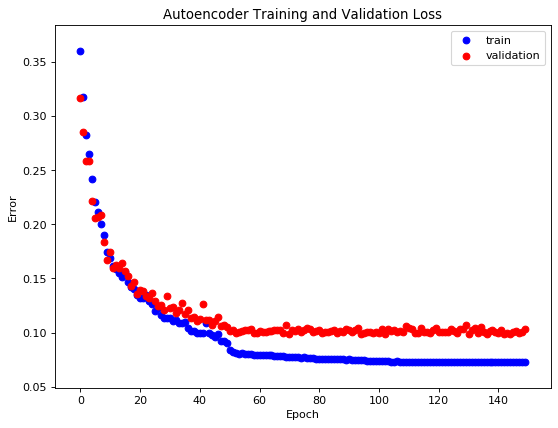

In [7]:
plt.figure(num=None, figsize=(8,6), dpi=80)
t = list(range(len(tr_loss)))
plt.scatter(t, tr_loss, c='b', label='train')
plt.scatter(t, val_loss, c='r', label='validation')
plt.legend(loc='upper right')
plt.title("Autoencoder Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Error')

  0%|                                                                                            | 0/38 [00:00<?, ?it/s]

results generated from train dataset


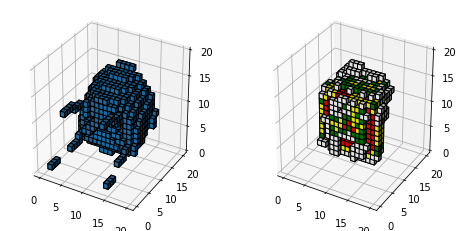

 11%|########8                                                                           | 4/38 [00:03<00:41,  1.22s/it]

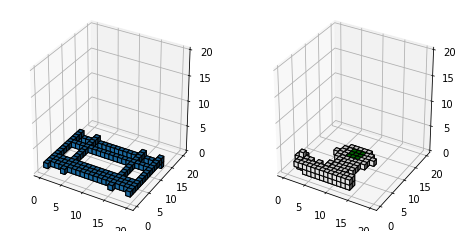

 21%|#################6                                                                  | 8/38 [00:06<00:19,  1.55it/s]

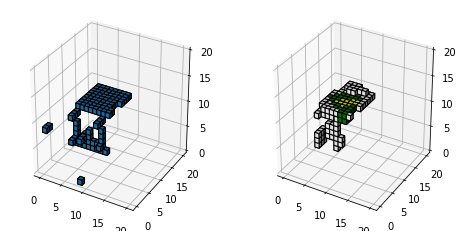

 32%|##########################2                                                        | 12/38 [00:09<00:12,  2.02it/s]

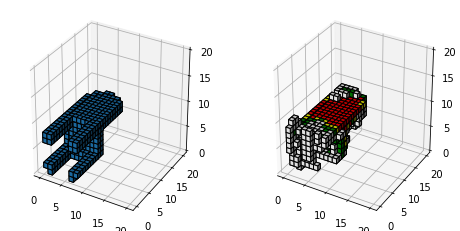

 42%|##################################9                                                | 16/38 [00:12<00:12,  1.78it/s]

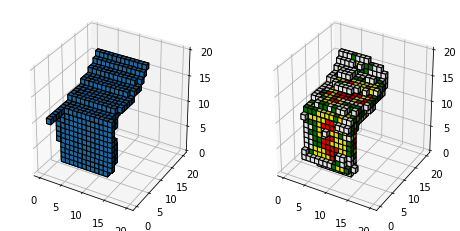

 53%|###########################################6                                       | 20/38 [00:16<00:10,  1.68it/s]

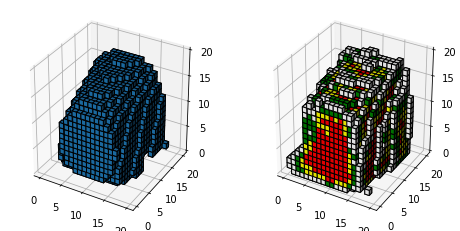

 63%|####################################################4                              | 24/38 [00:22<00:11,  1.22it/s]

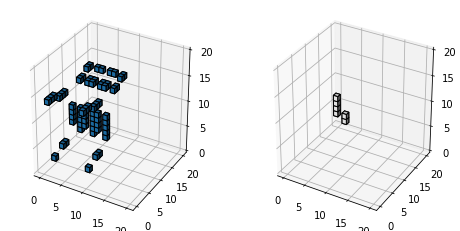

 74%|#############################################################1                     | 28/38 [00:24<00:05,  1.95it/s]

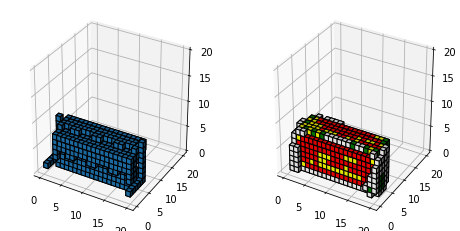

 84%|#####################################################################8             | 32/38 [00:28<00:03,  1.75it/s]

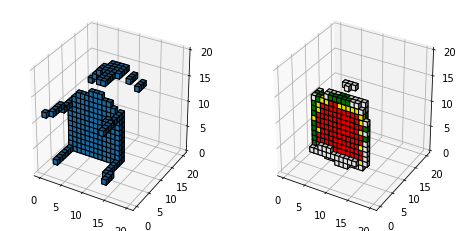

 95%|##############################################################################6    | 36/38 [00:31<00:01,  1.93it/s]

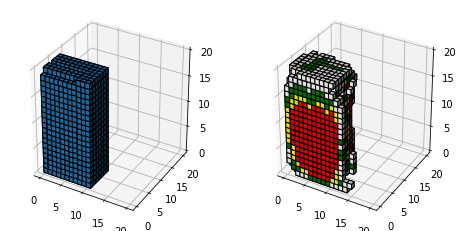

  0%|                                                                                            | 0/10 [00:00<?, ?it/s]

accuracy: 0.9673850740131579
results generated from test dataset


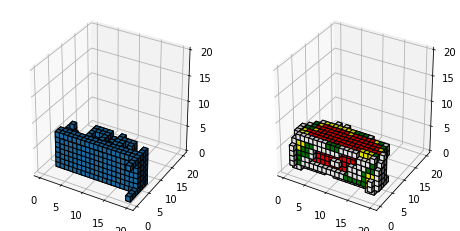

 40%|#################################6                                                  | 4/10 [00:03<00:06,  1.09s/it]

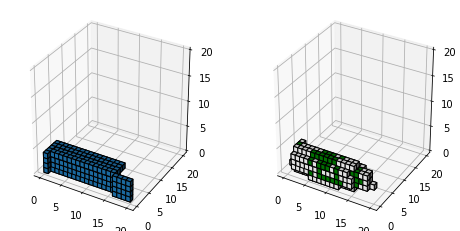

 80%|###################################################################2                | 8/10 [00:06<00:01,  1.58it/s]

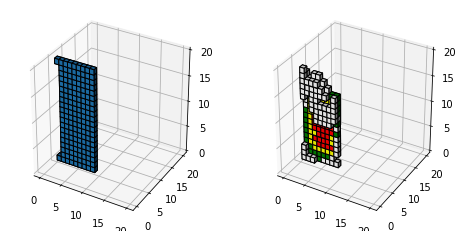

100%|###################################################################################| 10/10 [00:08<00:00,  1.15it/s]

accuracy: 0.9568932291666666


In [8]:
print('results generated from train dataset')
test_autoencoder(voxel_dataloader['train'], device)

print('results generated from test dataset')
test_autoencoder(voxel_dataloader['val'], device)

In [9]:
def save_autoencoder(encoder=None, decoder=None, reconst=None):
    if encoder == None:
        encoder = torch.load('./result/encoder.pt')
    if decoder == None:
        decoder = torch.load('./result/decoder.pt')
    if reconst == None:
        reconst = torch.load('./result/reconst.pt')


def load_autoencoder():
    encoder = torch.load('./result/encoder.pt')
    decoder = torch.load('./result/decoder.pt')
    reconst = torch.load('./result/reconst.pt')

    return encoder, decoder, reconst


# Imagenet Training

The training function will be used to test the performance of the AlexNet and Resnet architectures.

In [10]:
def train_imagenet(dataloader, device, encoder, imagenet, optimizer, path='imagenet.pt', num_epochs=10):
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    encoder.eval()
    tr_loss_his = []
    val_loss_his = []

    best_loss = 100

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            running_loss = 0.0
            
            if phase == 'train':
                imagenet.train()

            else:
                imagenet.eval()  # Set model to eval mode

            tqdm_loop = tqdm(dataloader[phase], ncols=120, ascii=True, position=0, leave=True)
            for index, (images, voxels, category) in enumerate(tqdm_loop):
                voxels = voxels[:, np.newaxis, :, :, :].type(dtype=torch.float32).to(device)
                voxels_scale = voxels * 255
                images = images.to(device)
                #images_scale = images * 255
                with torch.no_grad():
                    embedding = encoder(voxels_scale)

                outputs = imagenet(images)
                loss = criterion(outputs, embedding / 255)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()

            epoch_loss = running_loss / len(tqdm_loop)
            print('Epoch {} {} Loss: {:.4f}'.format(epoch, phase, epoch_loss))
            print()

            if phase == 'train':
                scheduler.step()
                tr_loss_his.append(epoch_loss)
            else:
                val_loss_his.append(epoch_loss)

            if phase=='val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                torch.save(imagenet, './result/' + path)

    return tr_loss_his, val_loss_his        


In [11]:
# Training of AlexNet model (see the top of the notebook for AlexNet class)
datapath = './Dset/'
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print(f'using device: {device}')

# split dataset into train and testing sets
img_dset = ImageVoxelDset(datapath + 'Rendered_Imgs', datapath + 'Voxel', ImgTransform=ToTensor())
train_size = int(0.8 * len(img_dset))
val_size = len(img_dset) - train_size
img_train_dset, img_val_dset = torch.utils.data.random_split(img_dset, [train_size, val_size])

voxel_img_dataloader = {}
voxel_img_dataloader['train'] = DataLoader(img_train_dset, batch_size=64, shuffle=True)
voxel_img_dataloader['val'] = DataLoader(img_val_dset, batch_size=64, shuffle=True)

encoder, decoder, reconst = load_autoencoder()
encoder = encoder.to(device)
img_net_alex = Alexnet().to(device)
path = 'alexnet.pt'

# train nonfrozen layers
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, img_net_alex.parameters()), 
                             lr=1e-4)
train_loss_his, val_loss_his = train_imagenet(voxel_img_dataloader, device, encoder, img_net_alex, optimizer, path, num_epochs=60)

Using cache found in C:\Users\John Penington/.cache\torch\hub\pytorch_vision_v0.6.0


using device: cuda:0


  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 0 train Loss: 1.5000



100%|#################################################################################| 169/169 [00:58<00:00,  2.90it/s]
U:\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Alexnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 0 val Loss: 1.1624



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 1 train Loss: 1.0307



100%|#################################################################################| 169/169 [00:51<00:00,  3.31it/s]


Epoch 1 val Loss: 0.8870



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 2 train Loss: 0.7647



100%|#################################################################################| 169/169 [00:51<00:00,  3.31it/s]


Epoch 2 val Loss: 0.6994



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 3 train Loss: 0.5922



100%|#################################################################################| 169/169 [00:51<00:00,  3.30it/s]


Epoch 3 val Loss: 0.5842



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 4 train Loss: 0.4708



100%|#################################################################################| 169/169 [00:51<00:00,  3.31it/s]


Epoch 4 val Loss: 0.5003



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 5 train Loss: 0.3917



100%|#################################################################################| 169/169 [00:51<00:00,  3.31it/s]


Epoch 5 val Loss: 0.4887



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 6 train Loss: 0.3321



100%|#################################################################################| 169/169 [00:51<00:00,  3.30it/s]


Epoch 6 val Loss: 0.4187



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 7 train Loss: 0.2866



100%|#################################################################################| 169/169 [00:51<00:00,  3.31it/s]


Epoch 7 val Loss: 0.4014



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 8 train Loss: 0.2528



100%|#################################################################################| 169/169 [00:51<00:00,  3.31it/s]


Epoch 8 val Loss: 0.3647



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 9 train Loss: 0.2251



100%|#################################################################################| 169/169 [00:51<00:00,  3.31it/s]


Epoch 9 val Loss: 0.3315



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 10 train Loss: 0.2033



100%|#################################################################################| 169/169 [00:51<00:00,  3.31it/s]


Epoch 10 val Loss: 0.3103



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 11 train Loss: 0.1884



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 11 val Loss: 0.3128



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 12 train Loss: 0.1712



100%|#################################################################################| 169/169 [00:51<00:00,  3.31it/s]


Epoch 12 val Loss: 0.2952



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 13 train Loss: 0.1613



100%|#################################################################################| 169/169 [00:51<00:00,  3.28it/s]


Epoch 13 val Loss: 0.2803



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 14 train Loss: 0.1493



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 14 val Loss: 0.2857



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 15 train Loss: 0.1383



100%|#################################################################################| 169/169 [00:51<00:00,  3.31it/s]


Epoch 15 val Loss: 0.2685



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 16 train Loss: 0.1349



100%|#################################################################################| 169/169 [00:51<00:00,  3.31it/s]


Epoch 16 val Loss: 0.2541



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 17 train Loss: 0.1249



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 17 val Loss: 0.2638



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 18 train Loss: 0.1198



100%|#################################################################################| 169/169 [00:50<00:00,  3.31it/s]


Epoch 18 val Loss: 0.2360



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 19 train Loss: 0.1148



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 19 val Loss: 0.2531



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 20 train Loss: 0.1097



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 20 val Loss: 0.2426



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 21 train Loss: 0.1036



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 21 val Loss: 0.2391



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 22 train Loss: 0.1006



100%|#################################################################################| 169/169 [00:51<00:00,  3.31it/s]


Epoch 22 val Loss: 0.2321



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 23 train Loss: 0.0979



100%|#################################################################################| 169/169 [00:51<00:00,  3.31it/s]


Epoch 23 val Loss: 0.2277



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 24 train Loss: 0.0923



100%|#################################################################################| 169/169 [00:50<00:00,  3.31it/s]


Epoch 24 val Loss: 0.2107



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 25 train Loss: 0.0896



100%|#################################################################################| 169/169 [00:51<00:00,  3.30it/s]


Epoch 25 val Loss: 0.2021



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 26 train Loss: 0.0865



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 26 val Loss: 0.2198



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 27 train Loss: 0.0826



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 27 val Loss: 0.2137



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 28 train Loss: 0.0798



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 28 val Loss: 0.2052



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 29 train Loss: 0.0789



100%|#################################################################################| 169/169 [00:50<00:00,  3.32it/s]


Epoch 29 val Loss: 0.1978



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 30 train Loss: 0.0612



100%|#################################################################################| 169/169 [00:51<00:00,  3.31it/s]


Epoch 30 val Loss: 0.1837



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 31 train Loss: 0.0544



100%|#################################################################################| 169/169 [00:50<00:00,  3.32it/s]


Epoch 31 val Loss: 0.1746



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 32 train Loss: 0.0508



100%|#################################################################################| 169/169 [00:50<00:00,  3.32it/s]


Epoch 32 val Loss: 0.1741



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 33 train Loss: 0.0488



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 33 val Loss: 0.1758



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 34 train Loss: 0.0475



100%|#################################################################################| 169/169 [00:51<00:00,  3.31it/s]


Epoch 34 val Loss: 0.1738



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 35 train Loss: 0.0460



100%|#################################################################################| 169/169 [00:51<00:00,  3.31it/s]


Epoch 35 val Loss: 0.1734



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 36 train Loss: 0.0452



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 36 val Loss: 0.1763



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 37 train Loss: 0.0441



100%|#################################################################################| 169/169 [00:51<00:00,  3.31it/s]


Epoch 37 val Loss: 0.1703



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 38 train Loss: 0.0429



100%|#################################################################################| 169/169 [00:50<00:00,  3.32it/s]


Epoch 38 val Loss: 0.1698



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 39 train Loss: 0.0419



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 39 val Loss: 0.1703



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 40 train Loss: 0.0415



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 40 val Loss: 0.1712



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 41 train Loss: 0.0408



100%|#################################################################################| 169/169 [00:50<00:00,  3.32it/s]


Epoch 41 val Loss: 0.1672



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 42 train Loss: 0.0405



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 42 val Loss: 0.1698



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 43 train Loss: 0.0401



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 43 val Loss: 0.1673



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 44 train Loss: 0.0390



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 44 val Loss: 0.1737



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 45 train Loss: 0.0386



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 45 val Loss: 0.1679



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 46 train Loss: 0.0380



100%|#################################################################################| 169/169 [00:50<00:00,  3.31it/s]


Epoch 46 val Loss: 0.1658



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 47 train Loss: 0.0374



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 47 val Loss: 0.1659



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 48 train Loss: 0.0372



100%|#################################################################################| 169/169 [00:51<00:00,  3.28it/s]


Epoch 48 val Loss: 0.1657



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 49 train Loss: 0.0369



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 49 val Loss: 0.1660



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 50 train Loss: 0.0363



100%|#################################################################################| 169/169 [00:51<00:00,  3.30it/s]


Epoch 50 val Loss: 0.1654



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 51 train Loss: 0.0366



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 51 val Loss: 0.1671



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 52 train Loss: 0.0356



100%|#################################################################################| 169/169 [00:50<00:00,  3.31it/s]


Epoch 52 val Loss: 0.1639



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 53 train Loss: 0.0354



100%|#################################################################################| 169/169 [00:51<00:00,  3.31it/s]


Epoch 53 val Loss: 0.1635



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 54 train Loss: 0.0354



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 54 val Loss: 0.1664



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 55 train Loss: 0.0346



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 55 val Loss: 0.1658



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 56 train Loss: 0.0345



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 56 val Loss: 0.1653



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 57 train Loss: 0.0342



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 57 val Loss: 0.1680



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 58 train Loss: 0.0338



  0%|                                                                                           | 0/675 [00:00<?, ?it/s]

Epoch 58 val Loss: 0.1662



  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

Epoch 59 train Loss: 0.0334



100%|#################################################################################| 169/169 [00:51<00:00,  3.31it/s]


Epoch 59 val Loss: 0.1622



Text(0, 0.5, 'Error')

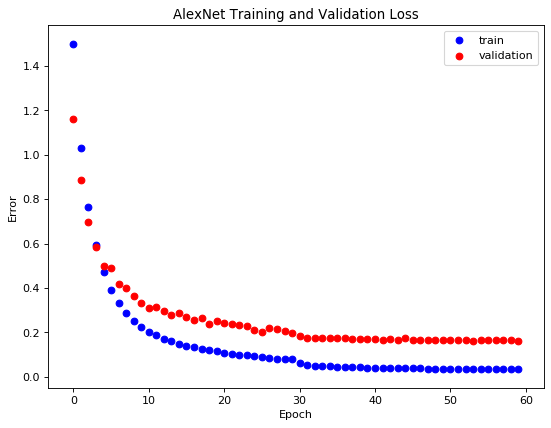

In [12]:
plt.figure(num=None, figsize=(8,6), dpi=80)
t = list(range(len(train_loss_his)))
plt.scatter(t, train_loss_his, c='b', label='train')
plt.scatter(t, val_loss_his, c='r', label='validation')
plt.legend(loc='upper right')
plt.title("AlexNet Training and Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Error')

In [13]:
"""
We were thinking about comparing resnet to alexnet but
the results were the same so we used alexnet for final imagenet
"""

# Training resnet
# img_net_resnet = Resnet().to(device)
# path = 'resnet.pt'
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, img_net_resnet.parameters()),
#                              lr=1e-4)
# train_loss_his, val_loss_his = train_imagenet(voxel_img_dataloader, device, encoder, img_net_resnet, optimizer, path, num_epochs=70)

In [14]:
# plt.figure(num=None, figsize=(8,6), dpi=80)
# t = list(range(len(train_loss_his)))
# plt.scatter(t, train_loss_his, c='b', label='train')
# plt.scatter(t, val_loss_his, c='r', label='test')
# plt.legend(loc='upper right')
# plt.title("ResNet Training and Validation Loss")
# plt.xlabel('Epoch')
# plt.ylabel('Error')

# Full Model Testing Functions

In [105]:
import torchvision

def print_stats(title, stats):
    """Print accuracy, precision, recall."""
    print(title, 'stats')
    print('-------------------')
    print('Autoencoder')
    print('Accuracy: {:.3f} Precision: {:.3f} Recall: {:.3f}'.format(*stats[0]))
    print('ImageNet')
    print('Accuracy: {:.3f} Precision: {:.3f} Recall: {:.3f}'.format(*stats[1]))
    print()

    
def test_model(dataloader, device, encoder=None, decoder=None, reconst=None,
               imagenet=None, path='imagenet.pt', show_images = False):
    if encoder == None:
        encoder = torch.load('./result/encoder.pt')
    if decoder == None:
        decoder = torch.load('./result/decoder.pt')
    if reconst == None:
        reconst = torch.load('./result/reconst.pt')
    if imagenet == None:
        imagenet = torch.load('./result/' + path)

    encoder.eval()
    decoder.eval()
    reconst.eval()
    imagenet.eval()
    
    total_pred = 0
    
    # category stats
    category_stats = {}
    for category in ['bed', 'cabinet', 'chair', 'sofa', 'table']:
        category_stats[category] = {
            'autoencoder': np.zeros(3),
            'imagenet': np.zeros(3),
            'num_pred': 0
        }

    with torch.no_grad():
        tqdm_loop = tqdm(dataloader, ncols=120, ascii=True, position=0, leave=True)
        for index, (image, voxels, cat) in enumerate(tqdm_loop):
            image = image.to(device)
            voxels = voxels[:, np.newaxis, :, :, :].type(dtype=torch.float32).to(device)

            output_img = decoder(reconst(imagenet(image) * 255)).cuda()
            output_voxel = decoder(reconst(encoder(voxels * 255))).cuda()
            
            if show_images:
                if index == 0:
                    voxel_dis = voxels.permute(0,1,2,4,3)
                    output_voxel_dis = output_voxel.permute(0,1,2,4,3)
                    output_img_dis = output_img.permute(0,1,2,4,3)
                    print('original voxel | reconstructed voxel | predicted voxel')
                    for i in range (10):
                        display(torchvision.transforms.ToPILImage()(image[i].cpu()))

                        plot_voxels_3_color(voxel_dis[i].cpu().squeeze(),
                                            output_voxel_dis[i].cpu().squeeze(),
                                            output_img_dis[i].cpu().squeeze())

            # get stats
            # add to correct category
            for i in range(len(cat)):
                auto_stats = get_statistics(output_voxel[i], voxels[i].data, 'auto')
                img_stats = get_statistics(output_img[i], voxels[i].data, 'img')

                category_stats[cat[i]]['autoencoder'] += auto_stats
                category_stats[cat[i]]['imagenet'] += img_stats
                category_stats[cat[i]]['num_pred'] += 1
    
    total_stats = {
        'autoencoder': np.zeros(3),
        'imagenet': np.zeros(3),
        'num_pred': 0
    }
    
    # print out statistics for each category
    for category, stats in category_stats.items():
        # add to total stats
        total_stats['autoencoder'] += stats['autoencoder']
        total_stats['imagenet'] += stats['imagenet']
        total_stats['num_pred'] += stats['num_pred']
        
        stats['autoencoder'] /= stats['num_pred']
        stats['imagenet'] /= stats['num_pred']
        
        print_stats(category, [stats['autoencoder'], stats['imagenet']])
    
    # print out total stats
    total_stats['autoencoder'] /= total_stats['num_pred']
    total_stats['imagenet'] /= total_stats['num_pred']
    print_stats('Total', [total_stats['autoencoder'], total_stats['imagenet']])
    
    return category_stats, total_stats


# AlexNet ImageNet Results

  0%|                                                                                           | 0/169 [00:00<?, ?it/s]

original voxel | reconstructed voxel | predicted voxel


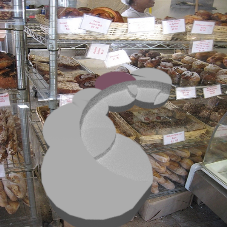

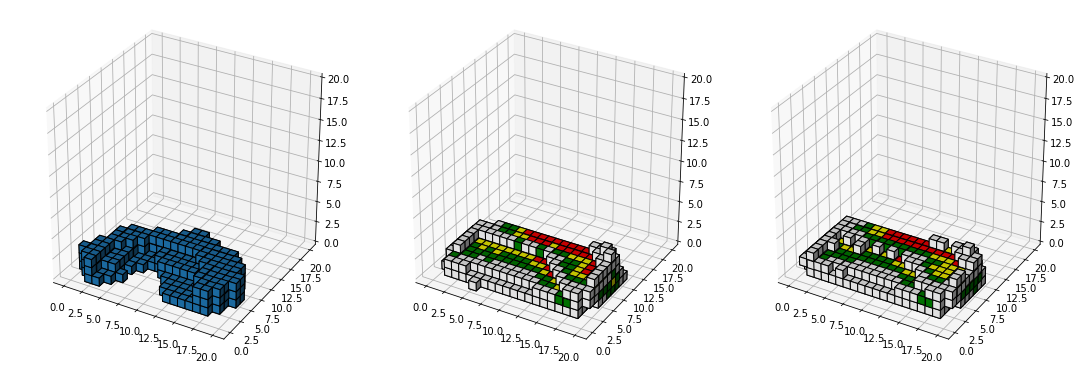

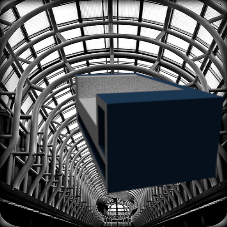

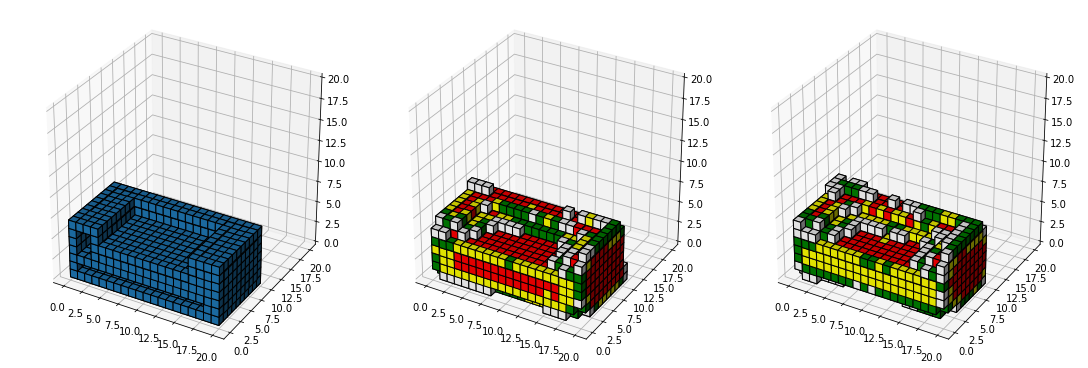

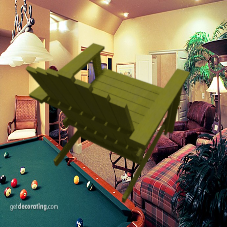

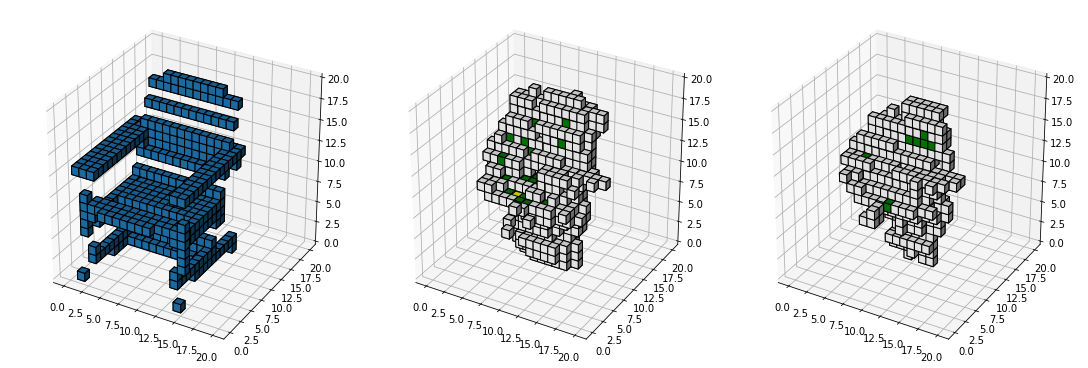

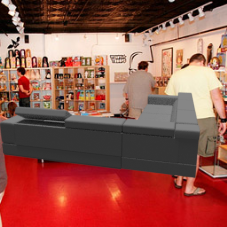

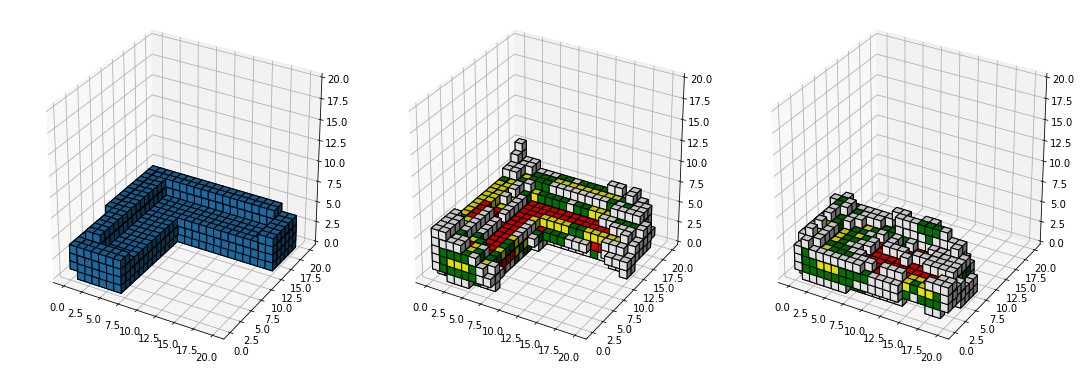

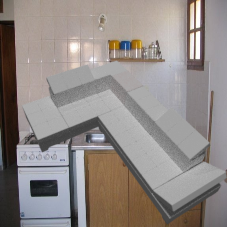

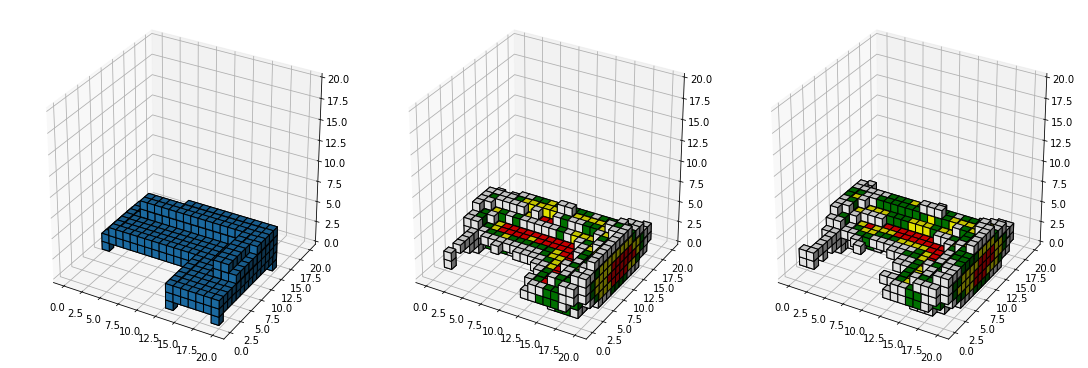

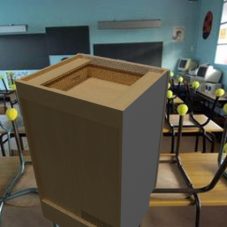

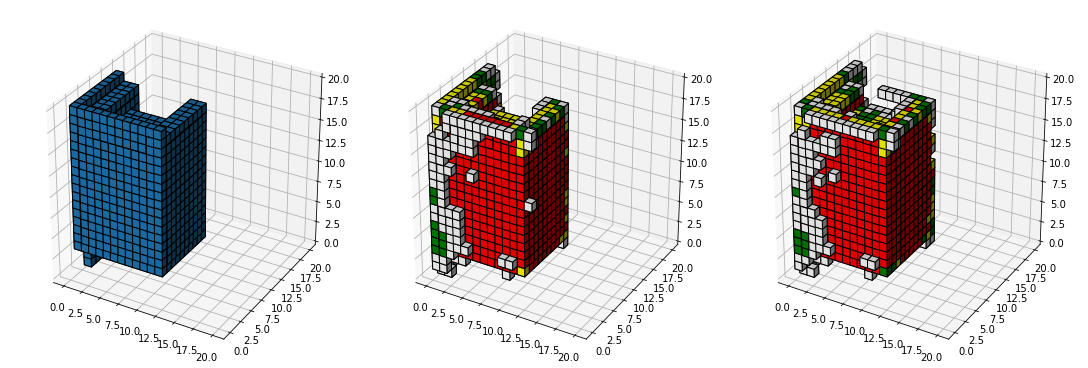

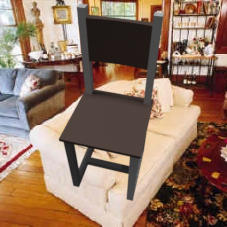

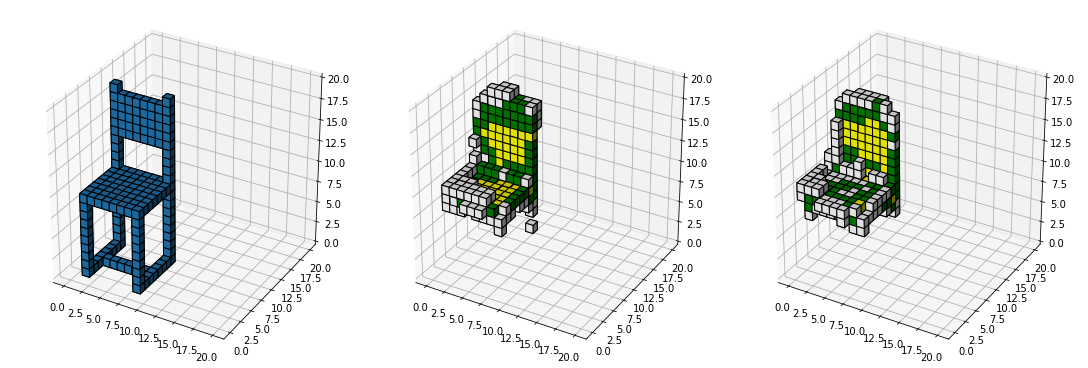

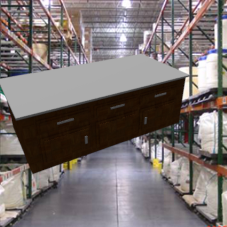

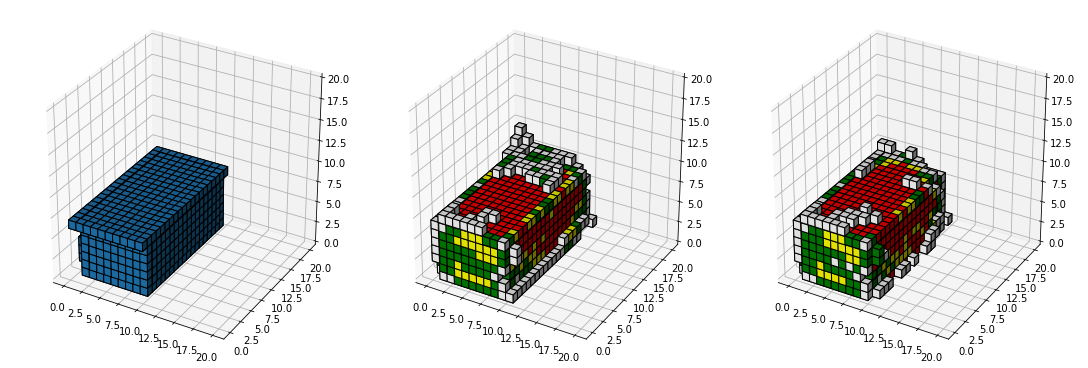

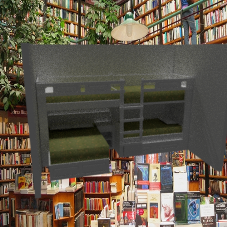

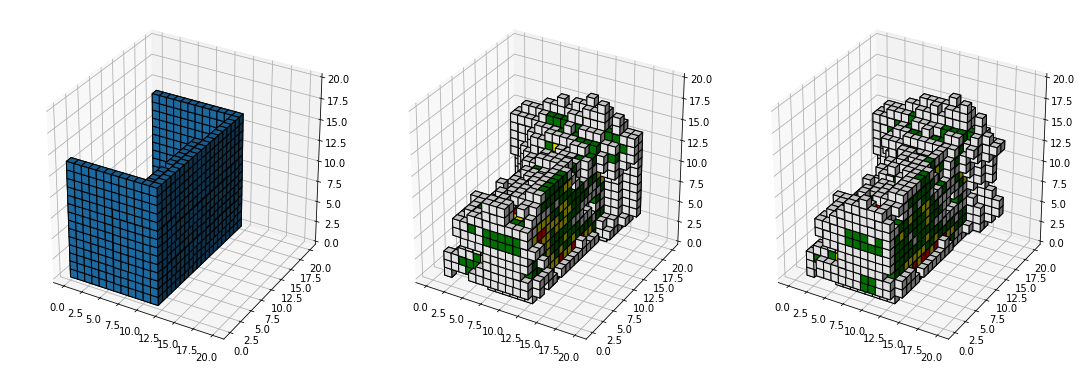

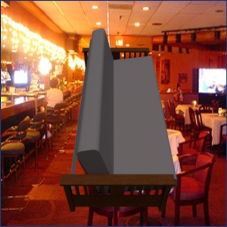

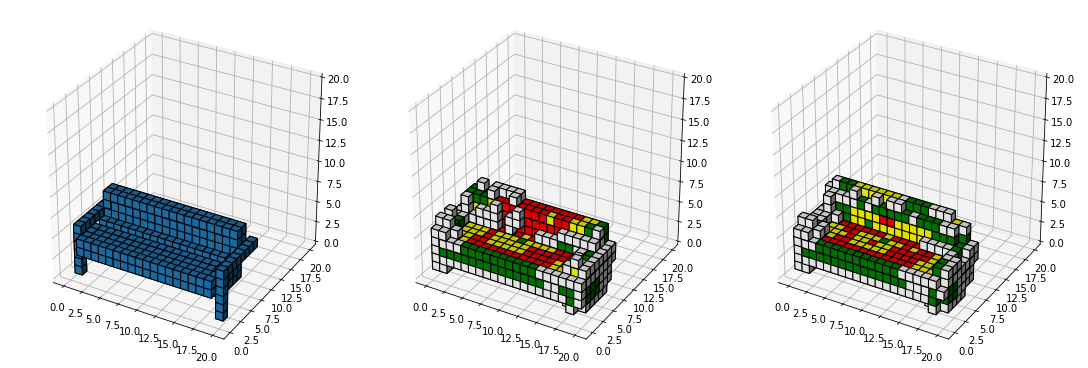

100%|#################################################################################| 169/169 [25:09<00:00,  8.93s/it]

bed stats
-------------------
Autoencoder
Accuracy: 0.940 Precision: 0.822 Recall: 0.644
ImageNet
Accuracy: 0.949 Precision: 0.596 Recall: 0.770

cabinet stats
-------------------
Autoencoder
Accuracy: 0.957 Precision: 0.929 Recall: 0.773
ImageNet
Accuracy: 0.953 Precision: 0.774 Recall: 0.829

chair stats
-------------------
Autoencoder
Accuracy: 0.958 Precision: 0.711 Recall: 0.580
ImageNet
Accuracy: 0.963 Precision: 0.450 Recall: 0.661

sofa stats
-------------------
Autoencoder
Accuracy: 0.969 Precision: 0.934 Recall: 0.745
ImageNet
Accuracy: 0.969 Precision: 0.743 Recall: 0.818

table stats
-------------------
Autoencoder
Accuracy: 0.956 Precision: 0.692 Recall: 0.555
ImageNet
Accuracy: 0.962 Precision: 0.416 Recall: 0.637

Total stats
-------------------
Autoencoder
Accuracy: 0.956 Precision: 0.818 Recall: 0.660
ImageNet
Accuracy: 0.959 Precision: 0.597 Recall: 0.744



In [106]:
# full results
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
alex_category_stats, alex_total = test_model(voxel_img_dataloader['val'], device,
                                             path='alexnet.pt',show_images=True)

# ResNet ImageNet Results

In [17]:
# full results
# resnet_category_stats, resent_total = test_model(voxel_img_dataloader['val'], device, path='resnet.pt')